In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import re
import shutil
import string

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [8]:
url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file(fname="stack_overflow_v1",
                                  origin=url,
                                  untar=True,
                                  cache_dir='C:/tensorflow_test/stack_overflow',
                                  cache_subdir='C:/tensorflow_test/stack_overflow'
)
print(dataset)

# dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow')
# print(dataset_dir)

C:/tensorflow_test/stack_overflow\stack_overflow_v1


In [9]:
batchsize = 50
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(directory='C:/tensorflow_test/stack_overflow/train',
                                                                  batch_size=batchsize,
                                                                  validation_split=0.2,
                                                                  subset='training',
                                                                  seed=seed )

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(directory='C:/tensorflow_test/stack_overflow/train',
                                                                batch_size=batchsize,
                                                                validation_split=0.2,
                                                                subset='validation',
                                                                seed=seed )

raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(directory='C:/tensorflow_test/stack_overflow/test',
                                                                 batch_size=batchsize,)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.


In [10]:
def custom_standerdization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

In [11]:
max_feature = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standerdization,
    max_tokens=max_feature,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [12]:
train_text = raw_train_ds.map(lambda x,y : x)
vectorize_layer.adapt(train_text)

In [13]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print(label_batch)
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

tf.Tensor(
[0 0 1 2 2 0 2 1 1 2 1 1 1 1 2 3 1 2 0 3 0 3 3 0 0 2 3 3 1 0 3 3 1 0 2 1 3
 0 2 3 0 0 0 2 0 0 1 0 3 3], shape=(50,), dtype=int32)
Review tf.Tensor(b'"is it necessary for the namespace to be the name of the file in blank? for example, i name my file(console application) \'hello\', so do i have to write namespace hello?if no, what is the purpose of adding namespace?"\n', shape=(), dtype=string)
Label csharp
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   6,   11, 1461,   12,    2,  941,    4,   33,    2,   56,    9,
           2,   39,    7,   16,   12,  137,    3,   56,   23,    1,  230,
         538,   50,   40,    3,   17,    4,  174,  941,    1,  136,   55,
           6,    2, 1121,    9,  405,  941,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  

In [14]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)
print(train_ds)

<MapDataset shapes: ((None, 250), (None,)), types: (tf.int64, tf.int32)>


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
emmbedding_dim = 16
model = tf.keras.Sequential(
    [
        layers.Embedding(input_dim=max_feature +1, output_dim=emmbedding_dim),
        layers.Dropout(0.2),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.2),
        
        layers.Dense(4)
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 68        
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [18]:
history = model.fit(x=train_ds,
                    validation_data=val_ds,
                    epochs=20
)

Epoch 1/20
128/128 [==============================] - 12s 92ms/step - loss: 1.3840 - accuracy: 0.2865 - val_loss: 1.3754 - val_accuracy: 0.4081
Epoch 2/20
128/128 [==============================] - 1s 5ms/step - loss: 1.3698 - accuracy: 0.4055 - val_loss: 1.3555 - val_accuracy: 0.5019
Epoch 3/20
128/128 [==============================] - 1s 6ms/step - loss: 1.3452 - accuracy: 0.4904 - val_loss: 1.3234 - val_accuracy: 0.5281
Epoch 4/20
128/128 [==============================] - 1s 7ms/step - loss: 1.3088 - accuracy: 0.5334 - val_loss: 1.2821 - val_accuracy: 0.5525
Epoch 5/20
128/128 [==============================] - 1s 7ms/step - loss: 1.2618 - accuracy: 0.5660 - val_loss: 1.2348 - val_accuracy: 0.5913
Epoch 6/20
128/128 [==============================] - 1s 5ms/step - loss: 1.2117 - accuracy: 0.6042 - val_loss: 1.1850 - val_accuracy: 0.6250
Epoch 7/20
128/128 [==============================] - 1s 7ms/step - loss: 1.1581 - accuracy: 0.6449 - val_loss: 1.1348 - val_accuracy: 0.6644
Epoc

In [19]:
loss, accuracy = model.evaluate(test_ds)

print("Loss:", loss)
print("Accuracy:", accuracy)

160/160 [==============================] - 42s 248ms/step - loss: 0.7374 - accuracy: 0.7617
Loss: 0.7373584508895874
Accuracy: 0.7617499828338623


In [20]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

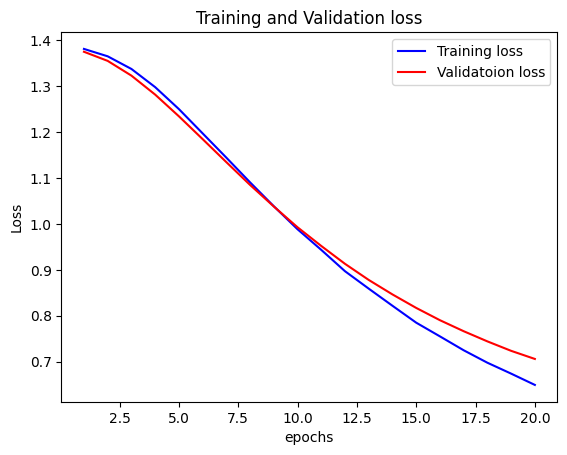

In [21]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validatoion loss')
plt.title('Training and Validation loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

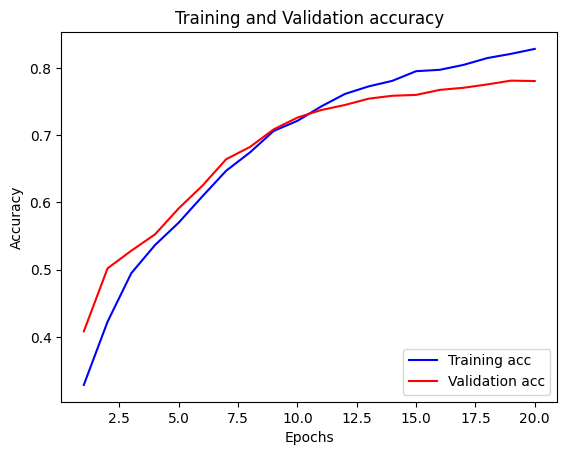

In [22]:
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [23]:
# export_model = TextVectorization layer + model
export_model = tf.keras.Sequential(
    [
        vectorize_layer,
        model,
        layers.Activation('sigmoid')
    ]
)

export_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

# Test it with 'raw_test_ds', which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

160/160 [==============================] - 5s 28ms/step - loss: 0.7352 - accuracy: 0.7598
0.7617499828338623
